# Tutorial: fitting a FSRQ broad-band SED using angpy and sherpa

In this tutorial we will show how to write a small `sherpa` wrapper of the `agnpy` functions that will allow us to fit the broad-band SED of PKS1510-089 measured during its gamma-ray flaring activity in 2015 [(Ahnen et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...603A..29A/abstract). We select the MWL SED corresponding to
the period identified in the paper as "Period B" (MJD 57164-57166). 

[sherpa](https://sherpa.readthedocs.io/en/latest/index.html) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.constants import k_B, m_e
from astropy.coordinates import Distance
from pathlib import Path
from astropy.table import Table
import matplotlib.pyplot as plt
import pkg_resources
mec2 = m_e.to("erg", equivalencies=u.mass_energy())

In [2]:
# import agnpy classes
import agnpy
from agnpy.emission_regions import Blob
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton, ExternalCompton
from agnpy.targets import RingDustTorus
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label, plot_sed
load_mpl_rc()

In [3]:
# import sherpa classes
from sherpa.models import model
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar, NelderMead

### sherpa wrapper of agnpy synchrotron, SSC and EC on DT
Now let us [follow the sherpa documentation](https://sherpa.readthedocs.io/en/latest/model_classes/usermodel.html) and define a model wrapping agnpy's functions to compute the Synchrotron, Synchrotron Self-Compton and External Compton on Dust Torus SEDs. We will assume a broken power law electorn distribution.

**NOTE:** for the parameters that vary over several orders of magnitude (i.e. normalisation and Lorentz factors of the electron distirbutions) it is better to provide to the model that will be used by the fitting routine a "scaled" version of them (e.g. their log10), such that larger steps might be covered with small parameters variation.

**NOTE:** instead of specifying two spectral indexes we will specifiy $p_1$ and $p_1 + \Delta p_1$, such that $p_2 = p_1 + \Delta p_1$. To tie together the height of the blob above the jet $r$ and the size of the emission region we will assume that they are related by the jet opening angle $\alpha_{\rm jet}$ via $R_b = r \alpha_{\rm jet}$.

In [4]:
class BrokenPowerLawEC_DT(model.RegriddableModel1D):
    """wrapper of agnpy's synchrotron, SSC and EC classes. A broken power-law is assumed for the electron spectrum.
    """
    
    def __init__(self, name="bpwl_ec"):
        
        # EED parameters
        self.log10_k_e = model.Parameter(name, "log10_k_e", -1., min=-5., max=1.)
        self.p1 = model.Parameter(name, "p1", 2.1, min=1.0, max=5.0)
        self.delta_p1 = model.Parameter(name, "delta_p1", 1., min=0.0, max=5.0)
        self.log10_gamma_b = model.Parameter(name, "log10_gamma_b", 3., min=1., max=6.) 
        self.log10_gamma_min = model.Parameter(name, "log10_gamma_min", 1., min=0., max=4.)
        self.log10_gamma_max = model.Parameter(name, "log10_gamma_max", 5., min=3., max=8.)
        
        # source general parameters 
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33)
        
        #emission region parameters 
        self.delta_D = model.Parameter(name, "delta_D", 10, min=1, max=50)        
        self.mu_s = model.Parameter(name, "mu_s", 0.9, min=0.0, max=1.0)
        self.log10_B = model.Parameter(name, "log10_B", 0., min=-3., max=1.)
        self.alpha_jet = model.Parameter(name, "alpha_jet", 0.05, min=0.0, max=1.1)
        self.log10_r = model.Parameter(name, "log10_r", 17., min=16., max=20.)

        # DT parameters
        self.log10_L_disk = model.Parameter(name, "log10_L_disk", 45., min=42., max=48.)
        self.xi_dt = model.Parameter(name, "xi_dt", 0.6, min=0.0, max=1.0)
        self.T_dt = model.Parameter(name, "T_dt", 1.e3, min=1.e2, max=1.e4)
        self.R_dt = model.Parameter(name, "R_dt", 2.5e18, min=1.e17, max=1.e19)
        
        model.RegriddableModel1D.__init__(self, name,
                                          (self.log10_k_e, self.p1, self.delta_p1, 
                                           self.log10_gamma_b, self.log10_gamma_min, self.log10_gamma_max, 
                                           self.z, self.d_L, 
                                           self.delta_D, self.mu_s, self.log10_B, self.alpha_jet, self.log10_r, 
                                           self.log10_L_disk, self.xi_dt, self.T_dt, self.R_dt))
        
    def calc(self, pars, x):
        """evaluate the model calling the agnpy functions"""
        (log10_k_e, p1, delta_p1, log10_gamma_b, log10_gamma_min, log10_gamma_max, 
         z, d_L, delta_D, mu_s, log10_B, alpha_jet, log10_r, log10_L_disk, xi_dt, T_dt, R_dt) = pars
        # add units, scale quantities
        x *= u.Hz
        k_e = 10**log10_k_e * u.Unit("cm-3")
        p2 = p1 + delta_p1
        gamma_b = 10**log10_gamma_b
        gamma_min = 10**log10_gamma_min
        gamma_max = 10**log10_gamma_max
        d_L *= u.cm
        B = 10**log10_B * u.G
        L_disk = 10**log10_L_disk * u.Unit("erg s-1")
        R_dt *= u.cm
        T_dt *= u.K
        r = 10**log10_r * u.cm
        R_b = r*alpha_jet
        eps_dt = 2.7 * (k_B * T_dt / mec2).to_value("")
        
        sed_synch = Synchrotron.evaluate_sed_flux(
            x, z, d_L, delta_D, B, R_b, BrokenPowerLaw, k_e, p1, p2, gamma_b, gamma_min, gamma_max, ssa=True
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            x, z, d_L, delta_D, B, R_b, BrokenPowerLaw, k_e, p1, p2, gamma_b, gamma_min, gamma_max
        )
        sed_dt = ExternalCompton.evaluate_sed_flux_dt(
            x, z, d_L, delta_D, mu_s, R_b, L_disk, xi_dt, eps_dt, R_dt, r, BrokenPowerLaw, k_e, p1, p2, gamma_b, gamma_min, gamma_max
        )
        return sed_synch + sed_ssc + sed_dt

### fitting with sherpa
Let us start here the procedure to fit with sherpa, first we read the data

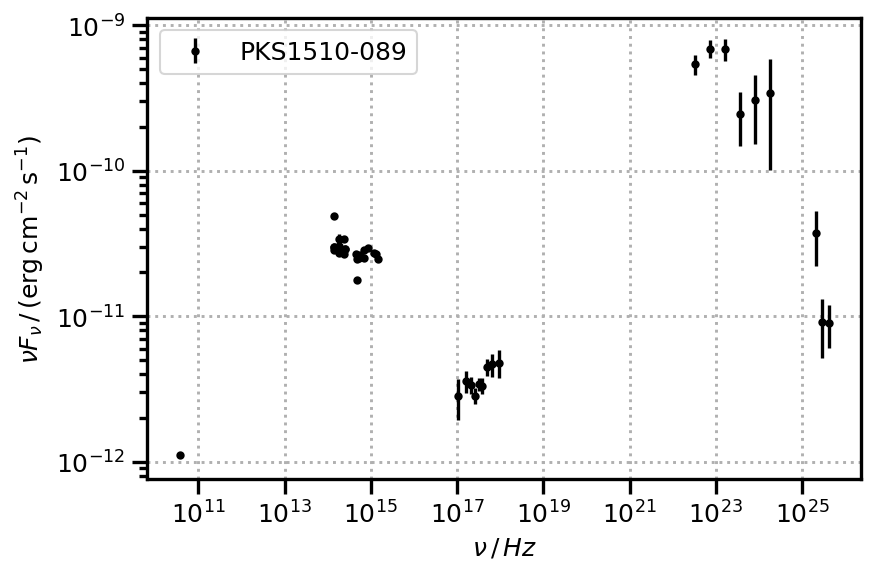

In [5]:
# read the 1D data
sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/PKS1510-089_2015.ecsv")
sed_table = Table.read(sed_path)
x = sed_table["E"]
y = sed_table["nuFnu"] 
y_err = sed_table["nuFnu_err_lo"]

# convert to classical SED units
x.convert_unit_to("Hz", equivalencies=u.spectral())
y.convert_unit_to("erg cm-2 s-1")
y_err.convert_unit_to("erg cm-2  s-1")

# plot the data
plt.errorbar(x, y, yerr=y_err, ls="", marker=".", color="k", label="PKS1510-089")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(sed_x_label)
plt.ylabel(sed_y_label)
plt.legend()
plt.show()

Then we pass the data in the `Data1D` object provided by sherpa

In [6]:
# load them in a sherpa data object
sed = data.Data1D("sed", x, y, staterror=y_err)
print(sed)

name      = sed
x         = Float64[43]
y         = Float64[43]
staterror = Float64[43]
syserror  = None


Create an instance of the model wrapping the synchrotron, SSC and EC on DT emissions.

In [7]:
# global parameters of the blob and the DT

# galaxy distance
z = 0.361
d_L = Distance(z=z).to("cm") 

# blob 
Gamma = 20
alpha_jet = 1 / Gamma # jet opening angle 
delta_D = 20
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2)) # jet relativistic speed
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta # viewing angle

# dust torus 
L_disk = 6.7e45 * u.Unit("erg s-1") # disk luminosity
xi_dt = 0.6 # fraction of disk luminosity reprocessed by the DT
R_dt = 6.47e18 * u.cm  # radius of DT
T_dt = 1e3 * u.K

# location of the emission region
r = 6e17 * u.cm

In [8]:
# instance of the model wrapping angpy functionalities
model = BrokenPowerLawEC_DT()

# EED parameters
model.log10_k_e = np.log10(0.1)
model.p1.val = 2.1
model.delta_p1 = 1
model.log10_gamma_b = np.log10(150)
model.log10_gamma_min = np.log10(5)
model.log10_gamma_min.freeze()
model.log10_gamma_max = np.log10(4e4)
model.log10_gamma_max.freeze()

# source general parameters 
model.z = z
model.z.freeze()
model.d_L = d_L.cgs.value
model.d_L.freeze()

# emission region parameters
model.delta_D = delta_D
model.delta_D.freeze()
model.mu_s = mu_s
model.mu_s.freeze()
model.alpha_jet  = alpha_jet
model.alpha_jet.freeze()

model.log10_L_disk = np.log10(L_disk.to_value("erg s-1"))
model.log10_L_disk.freeze()
model.xi_dt = 0.6
model.xi_dt.freeze()
model.T_dt = T_dt.to("K").value
model.T_dt.freeze()
model.R_dt = R_dt.to("cm").value
model.R_dt.freeze()

print(model)

bpwl_ec
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   bpwl_ec.log10_k_e thawed           -1           -5            1           
   bpwl_ec.p1   thawed          2.1            1            5           
   bpwl_ec.delta_p1 thawed            1            0            5           
   bpwl_ec.log10_gamma_b thawed      2.17609            1            6           
   bpwl_ec.log10_gamma_min frozen      0.69897            0            4           
   bpwl_ec.log10_gamma_max frozen      4.60206            3            8           
   bpwl_ec.z    frozen        0.361         0.01            1           
   bpwl_ec.d_L  frozen  6.12885e+27        1e+25        1e+33           
   bpwl_ec.delta_D frozen           20            1           50           
   bpwl_ec.mu_s frozen     0.998749            0            1           
   bpwl_ec.log10_B thawed            0           -3            1         

Now we define the Fit procedure choosing the statistics (chi2) and the minimisation method. We will fit only the data between $10^{10}\,{\rm Hz}$ and $10^{27}\,{\rm Hz}$, avoiding the lowest-energy radio data usually attributed to the extended jet emission.

In [9]:
# fit using the Levenberg-Marquardt optimiser
fitter = Fit(sed, model, stat=Chi2(), method=LevMar())
min_x = 1e10
max_x = 1e27
sed.notice(min_x, max_x)
print(fitter)

data      = sed
model     = bpwl_ec
stat      = Chi2
method    = LevMar
estmethod = Covariance


In [10]:
%%time
# perform the fit and time it!
results = fitter.fit()
print("-- fit succesful?", results.succeeded)
print(results.format())

-- fit succesful? True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 1.63178e+06
Final fit statistic   = 7373.6 at function evaluation 424
Data points           = 43
Degrees of freedom    = 37
Probability [Q-value] = 0
Reduced statistic     = 199.287
Change in statistic   = 1.62441e+06
   bpwl_ec.log10_k_e   -1.57681     +/- 0.731796    
   bpwl_ec.p1     1.46251      +/- 0.844819    
   bpwl_ec.delta_p1   1.91373      +/- 0.840528    
   bpwl_ec.log10_gamma_b   2.93319      +/- 0.2204      
   bpwl_ec.log10_B   -0.469516    +/- 0.0226705   
   bpwl_ec.log10_r   17.8069      +/- 0.056668    
CPU times: user 1min 37s, sys: 10 s, total: 1min 47s
Wall time: 1min 47s


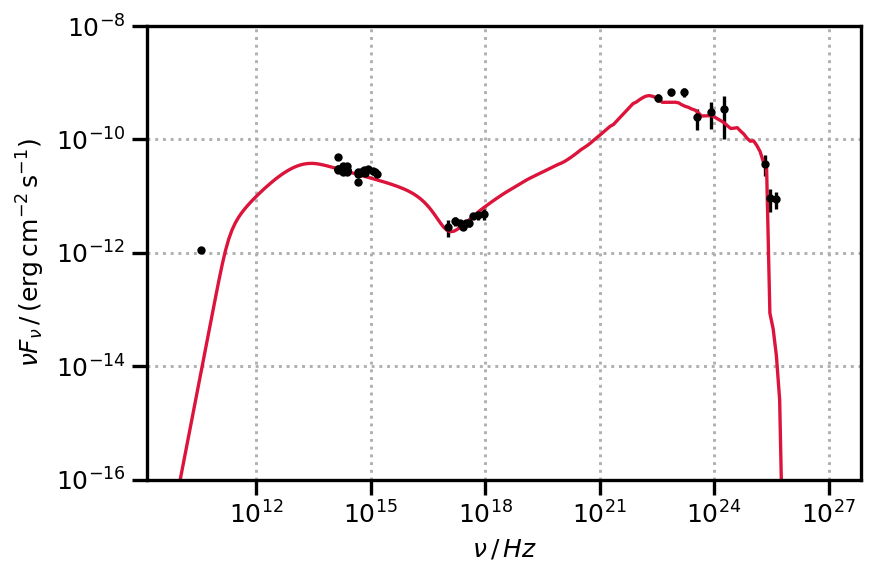

In [11]:
# plot the results!
x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
plt.errorbar(sed.x, sed.y, yerr=sed.staterror, marker=".", ls="", color="k")
plot_sed(x, model(x), ls="-", color="crimson")
plt.ylim([1e-16, 1e-8])
plt.show()

### draw individual SED components using agnpy
Let us now use the sherpa results and draw the individual SED components

In [12]:
# EED
k_e = 10**model.log10_k_e.val * u.Unit("cm-3")
B = 10**model.log10_B.val * u.G
p1 = model.p1.val
p2 = p1 + model.delta_p1.val
gamma_b = 10**model.log10_gamma_b.val
gamma_min = 10**model.log10_gamma_min.val
gamma_max = 10**model.log10_gamma_max.val
r = 10**model.log10_r.val * u.cm
R_b = r * alpha_jet

# blob definition
parameters = {
    "p1": p1,
    "p2": p2,
    "gamma_b": gamma_b,
    "gamma_min": gamma_min,
    "gamma_max": gamma_max,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
blob = Blob(R_b, z, delta_D, Gamma, B, k_e, spectrum_dict, spectrum_norm_type="differential")
blob.set_gamma_size(400)
print(blob)

# DT definition
dt = RingDustTorus(L_disk, xi_dt, T_dt, R_dt=R_dt)
print(dt)

# synch, SSC, EC defintion
nu = np.logspace(9, 30, 100) * u.Hz
synch = Synchrotron(blob, ssa=True)
ssc = SynchrotronSelfCompton(blob, synch)
ec_dt = ExternalCompton(blob, dt, r)
dt_sed = dt.sed_flux(nu, blob.z)
# compute the SEDs
ec_dt_sed = ec_dt.sed_flux(nu)
ssc_sed = ssc.sed_flux(nu)
synch_sed = synch.sed_flux(nu) 
total = (synch_sed + ssc_sed + ec_dt_sed)

* spherical emission region
 - R_b (radius of the blob): 3.21e+16 cm
 - V_b (volume of the blob): 1.38e+50 cm3
 - z (source redshift): 0.36
 - d_L (source luminosity distance):6.13e+27 cm
 - delta_D (blob Doppler factor): 2.00e+01
 - Gamma (blob Lorentz factor): 2.00e+01
 - Beta (blob relativistic velocity): 9.99e-01
 - theta_s (jet viewing angle): 2.87e+00 deg
 - B (magnetic field tangled to the jet): 3.39e-01 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electron spectrum
 - broken power law
 - k_e: 2.65e-02 1 / cm3
 - p1: 1.46
 - p2: 3.38
 - gamma_b: 8.57e+02
 - gamma_min: 5.00e+00
 - gamma_max: 4.00e+04

* Ring Dust Torus:
 - L_disk (accretion disk luminosity): 6.70e+45 erg / s
 - xi_dt (fraction of the disk radiation reprocessed by the torus): 6.00e-01
 - T_dt (temperature of the dust torus): 1.00e+03 K
 - R_dt (radius of the torus): 6.47e+18 cm



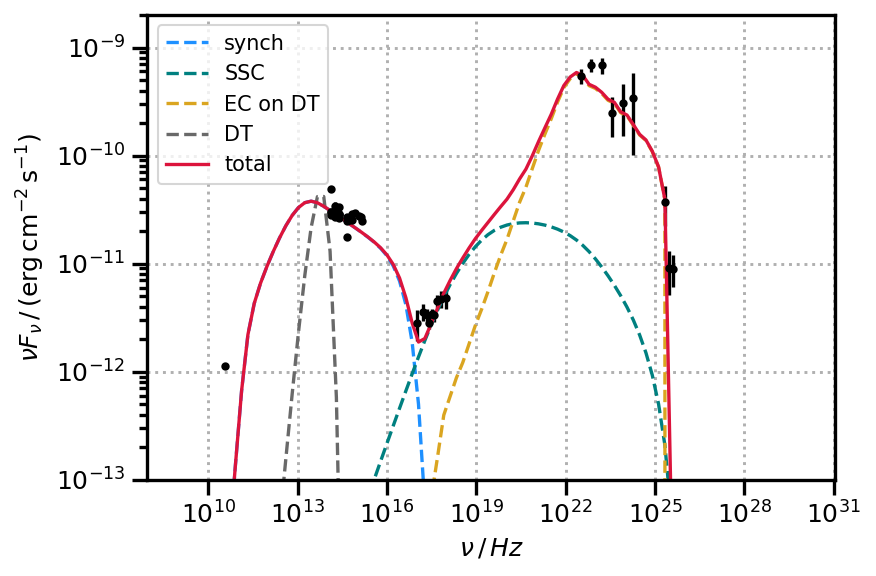

In [13]:
plot_sed(nu, synch_sed, ls="--", color="dodgerblue", label="synch")
plot_sed(nu, ssc_sed, ls="--", color="teal", label="SSC")
plot_sed(nu, ec_dt_sed, ls="--", color="goldenrod", label="EC on DT")
plt.plot(nu, dt_sed, ls="--", color="dimgray", label="DT")
plt.plot(nu, total, ls="-", label="total", color="crimson")
plt.errorbar(sed.x, sed.y, yerr=sed.staterror, marker=".", ls="", color="k")
plt.ylim(1e-13, 2e-9)
plt.legend(fontsize=10)
plt.show()